# Conditional Flow Matching

This notebook is a self-contained example of conditional flow matching. We implement a number of different simulation-free methods for learning flow models. They differ based on the interpolant used and the loss function used to train them.

In this notebook we implement 5 models that can map from a source distribution $q_0$ to a target distribution $q_1$:
* Conditional Flow Matching (CFM)
    * This is equivalent to the basic (non-rectified) formulation of "Flow Straight and Fast: Learning to Generate and Transfer Data with Rectified Flow" [(Liu et al. 2023)](https://openreview.net/forum?id=XVjTT1nw5z)
    * Is similar to "Stochastic Interpolants" [(Albergo et al. 2023)](https://openreview.net/forum?id=li7qeBbCR1t) with a non-variance preserving interpolant.
    * Is similar to "Flow Matching" [(Lipman et al. 2023)](https://openreview.net/forum?id=PqvMRDCJT9t) but conditions on both source and target.
* Optimal Transport CFM (OT-CFM), which directly optimizes for dynamic optimal transport
* Schrödinger Bridge CFM (SB-CFM), which optimizes for Schrödinger Bridge probability paths
* "Building Normalizing Flows with Stochastic Interpolants" [(Albergo et al. 2023)](https://openreview.net/forum?id=li7qeBbCR1t) this corresponds to "VP-CFM" in our README referring to its variance preserving properties.
* "Action Matching: Learning Stochastic Dynamics From Samples" [(Neklyudov et al. 2022)](https://arxiv.org/abs/2210.06662)

Note that this Flow Matching is different from the Generative Flow Network Flow Matching losses. Here we specifically regress against continuous flows, rather than matching inflows and outflows.

In [5]:
import math
import os
import time
from tqdm import tqdm

print(os.popen("dir").read())

import matplotlib.pyplot as plt
import numpy as np
import ot as pot
import torch
import torchdyn
from torchdyn.core import NeuralODE
from torchdyn.datasets import generate_moons
from torchdyn.utils import plot_2D_state_space, plot_static_vector_field

from torchcfm.conditional_flow_matching import *
from torchcfm.models.models import *
from torchcfm.utils import *


savedir = "models/random-moons"
os.makedirs(savedir, exist_ok=True)

def sample_random(n):
    return torch.randn(n, 2)

 Volume in drive C is Acer
 Volume Serial Number is 9E5C-6D0E

 Directory of c:\Users\shahs\conditional-flow-matching

07/08/2024  14:36    <DIR>          .
26/07/2024  15:38    <DIR>          ..
23/07/2024  23:31    <DIR>          .github
23/07/2024  23:31             2,398 .gitignore
23/07/2024  23:31             3,757 .pre-commit-config.yaml
23/07/2024  23:31    <DIR>          assets
23/07/2024  23:44    <DIR>          build
23/07/2024  23:44    <DIR>          dist
23/07/2024  23:31    <DIR>          examples
23/07/2024  23:31             1,092 LICENSE
30/07/2024  09:29           227,798 model-comparison-plotting.ipynb
25/07/2024  02:09    <DIR>          models
23/07/2024  23:31               791 pyproject.toml
23/07/2024  23:31            14,547 README.md
23/07/2024  23:31               194 requirements.txt
07/08/2024  14:41             2,436 retrain.py
23/07/2024  23:31    <DIR>          runner
23/07/2024  23:31             1,389 runner-requirements.txt
23/07/2024  23:31          

### Conditional Flow Matching

First we implement the basic conditional flow matching. As in the paper, we have
$$
\begin{align}
z &= (x_0, x_1) \\
q(z) &= q(x_0)q(x_1) \\
p_t(x | z) &= \mathcal{N}(x | t * x_1 + (1 - t) * x_0, \sigma^2) \\
u_t(x | z) &= x_1 - x_0
\end{align}
$$
When $\sigma = 0$ this is equivalent to zero-steps of rectified flow. We find that small $\sigma$ helps to regularize the problem ymmv.

In [17]:
%%time
def learn(l, synthModel, show = False):
    sigma = 0.1
    dim = 2
    batch_size = 1000
    model = MLP(dim=dim, time_varying=True)
    optimizer = torch.optim.Adam(model.parameters())
    FM = ConditionalFlowMatcher(sigma=sigma)


    for k in tqdm(range(5000), disable=True):
        optimizer.zero_grad()
    
        x0 = sample_random(batch_size)
        if synthModel == None: 
            x1 = sample_moons(batch_size)
        else:
            with torch.no_grad():
                sn = synthModel.trajectory(sample_random(batch_size * l), t_span=torch.linspace(0, 1, 100))
                sn = sn[-1, :batch_size * l, :]
            x1 = torch.cat((sample_moons(batch_size - len(sn)), sn))
        
        t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)
        vt = model(torch.cat([xt, t[:,None]], dim=-1))
        loss = torch.mean((vt - ut) ** 2)

        loss.backward()
        optimizer.step()

        if k % 5000 == 4999 and show:        
            node = NeuralODE(torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4)
            with torch.no_grad():
                traj = node.trajectory(sample_random(1000), t_span=torch.linspace(0, 1, 100))
                plot_trajectories(traj.cpu().numpy(), path)

    return node
    
# torch.save(model, f"{savedir}/cfm_v1.pt")

CPU times: total: 0 ns
Wall time: 0 ns


In [ ]:
synthModel = learn(0, None, True)

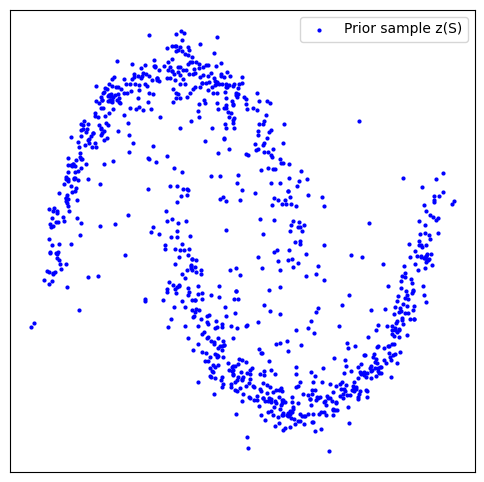

  0%|          | 0/10 [00:00<?, ?it/s]

Training iteration 0


  0%|          | 0/10 [14:23<?, ?it/s]


KeyboardInterrupt: 

In [18]:
l = 1
training_iterations = 10

print("Training Iteration 0")
synth = learn(l, None, True)
for t in tqdm(range(training_iterations)):
    print(f"Training iteration {t+1}")
    # if t % 5 == 0:
    #     synth = learn(l, synth, True)
    # else:
    synth = learn(l, synth, True)
    

### Optimal Transport Conditional Flow Matching

Next we implement optimal transport conditional flow matching. As in the paper, here we have
$$
\begin{align}
z &= (x_0, x_1) \\
q(z) &= \pi(x_0, x_1) \\
p_t(x | z) &= \mathcal{N}(x | t * x_1 + (1 - t) * x_0, \sigma^2) \\
u_t(x | z) &= x_1 - x_0
\end{align}
$$
where $\pi$ is the joint of an exact optimal transport matrix. We first sample random $x_0, x_1$, then resample according to the optimal transport matrix as computed with the python optimal transport package. We use the 2-Wasserstein distance with an $L^2$ ground distance for equivalence with dynamic optimal transport.

5000: loss 0.216 time 153.93


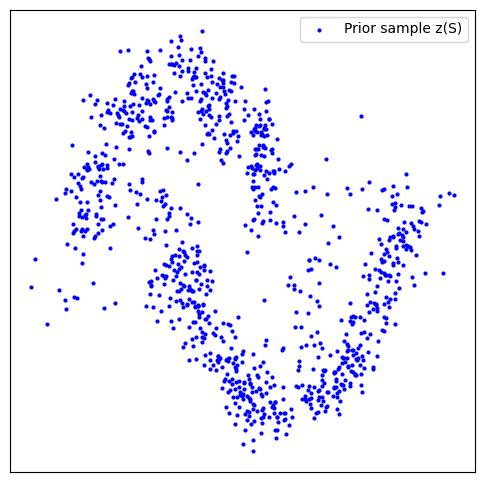

KeyboardInterrupt: 

In [5]:
%%time
sigma = 0.1
dim = 2
batch_size = 256
model = MLP(dim=dim, time_varying=True)
optimizer = torch.optim.Adam(model.parameters())
FM = ExactOptimalTransportConditionalFlowMatcher(sigma=sigma)

start = time.time()
for k in range(20000):
    optimizer.zero_grad()

    x0 = sample_8gaussians(batch_size)
    x1 = sample_moons(batch_size)

    t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)

    vt = model(torch.cat([xt, t[:, None]], dim=-1))
    loss = torch.mean((vt - ut) ** 2)

    loss.backward()
    optimizer.step()

    if (k + 1) % 5000 == 0:
        end = time.time()
        print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
        start = end
        node = NeuralODE(
            torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
        )
        with torch.no_grad():
            traj = node.trajectory(
                sample_8gaussians(1024),
                t_span=torch.linspace(0, 1, 100),
            )
            plot_trajectories(traj.cpu().numpy())
torch.save(model, f"{savedir}/otcfm_v1.pt")

### Schrödinger Bridge Conditional Flow Matching

Next we implement Schrödinger Bridge conditional flow matching. As in the paper, here we have
$$
\begin{align}
z &= (x_0, x_1) \\
q(z) &= \pi_{2 \sigma^2} (x_0, x_1) \\
p_t(x | z) &= \mathcal{N}( x \mid t x_1 + (1 - t) x_0, t(1-t)\sigma^2)\\
u_t(x | z) &= \frac{1-2t}{2t(1-t)}(x - ( t x_1 + (1-t)x_0) ) + (x_1 - x_0)
\end{align}
$$
where $\pi_{2 \sigma^2}$ is the joint of a **Sinkhorn** optimal transport matrix with regularization $2 \sigma^2$. As in OT-CFM We first sample random $x_0, x_1$, then resample according to the optimal transport matrix as computed with the python optimal transport package. We use the 2-Wasserstein distance with an $L^2$ ground distance for equivalence with the probability flow of a Schrödinger Bridge with reference measure $\sigma W$.

Note that the drift $v_\theta(t,x)$ we learn is *not* equivalent to the drift of the stochastic system, instead it is the drift of the equivalent probability flow ODE, however they are related through $p_t(x)$.

Also note that we use a larger $\sigma$ here both for convergence of the Sinkhorn algorithm and to make the differences more visible.

5000: loss 4.550 time 85.70


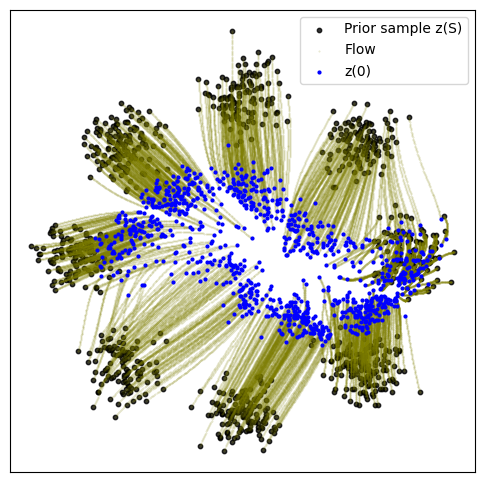

10000: loss 1.237 time 86.54


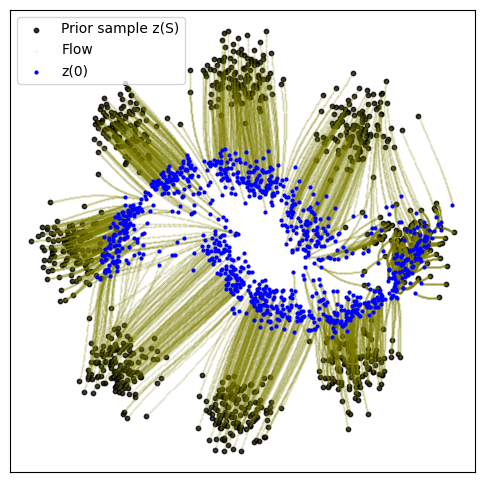

15000: loss 0.721 time 87.70


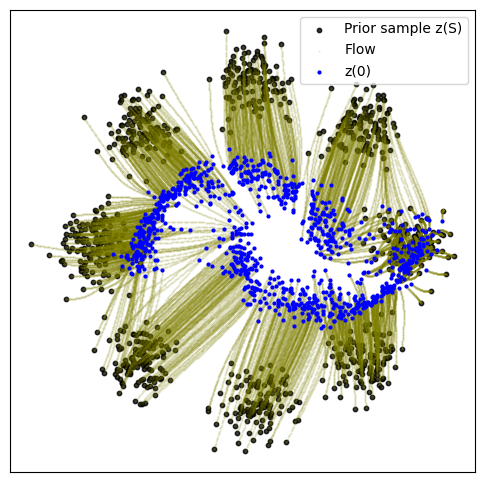

20000: loss 0.680 time 86.27


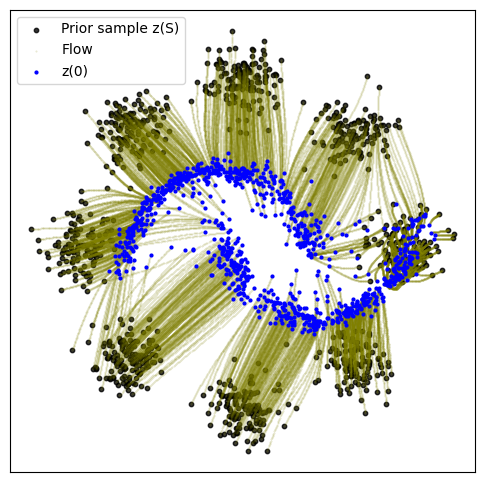

CPU times: user 52min 1s, sys: 1.9 s, total: 52min 2s
Wall time: 5min 47s


In [5]:
%%time
sigma = 0.5
dim = 2
batch_size = 256
model = MLP(dim=dim, time_varying=True)
optimizer = torch.optim.Adam(model.parameters())
# For best performance, use ot_method="exact". To follow the theory, use ot_method="sinkhorn"
FM = SchrodingerBridgeConditionalFlowMatcher(sigma=sigma, ot_method="exact")

start = time.time()
for k in range(20000):
    optimizer.zero_grad()

    x0 = sample_8gaussians(batch_size)
    x1 = sample_moons(batch_size)

    t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)

    vt = model(torch.cat([xt, t[:, None]], dim=-1))
    loss = torch.mean((vt - ut) ** 2)

    loss.backward()
    optimizer.step()

    if (k + 1) % 5000 == 0:
        end = time.time()
        print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
        start = end
        node = NeuralODE(
            torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
        )
        with torch.no_grad():
            traj = node.trajectory(
                sample_8gaussians(1024),
                t_span=torch.linspace(0, 1, 100),
            )
            plot_trajectories(traj.cpu().numpy())
torch.save(model, f"{savedir}/sbcfm_v1.pt")

### Stochastic Interpolants (Albergo et al. 2023)

Next we try a variant suggested by Albergo et al. 2023, Stochastic Interpolants. This is an interesting interpolant because it has some variance preservation properties. Note that the authors consider $\sigma = 0$ (i.e. a Dirac around $\mu_t$) but we keep the general form for consistency. We also refer to this $t$ schedule as "Variance Preserving" and call this VP-CFM. The authors also consider optimizing over more general interpolants $I_t = \alpha(t) x_0 + \beta(t) x_1$ with minor constraints. In our notation, we have
$$
\begin{align}
z &= (x_0, x_1) \\
q(z) &= q(x_0)q(x_1) \\
p_t(x | z) &= \mathcal{N}(x | \cos \left (\frac{\pi t}{2}  \right ) x_0 + \sin \left (\frac{\pi t}{2}  \right ) x_1, \sigma^2) \\
u_t(x | z) &= \frac{\pi}{2} \left (\cos (\frac{\pi t}{2}) x_1 - \sin(\frac{\pi t}{2}) x_0 \right )
\end{align}
$$

5000: loss 13.600 time 12.73


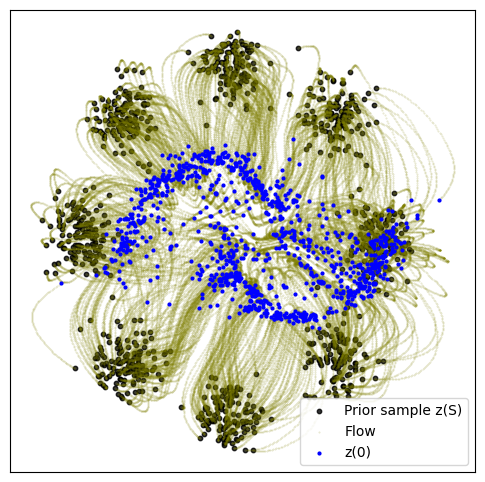

10000: loss 13.479 time 13.79


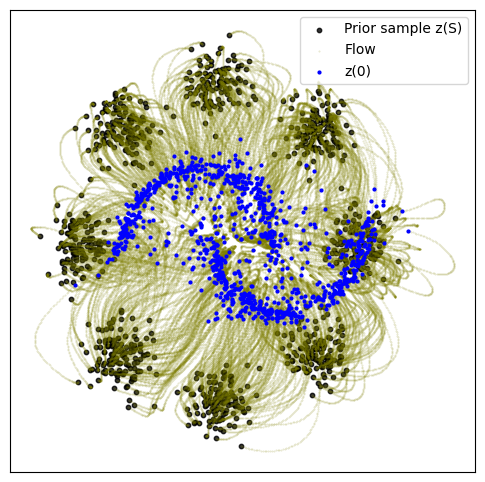

15000: loss 13.023 time 14.19


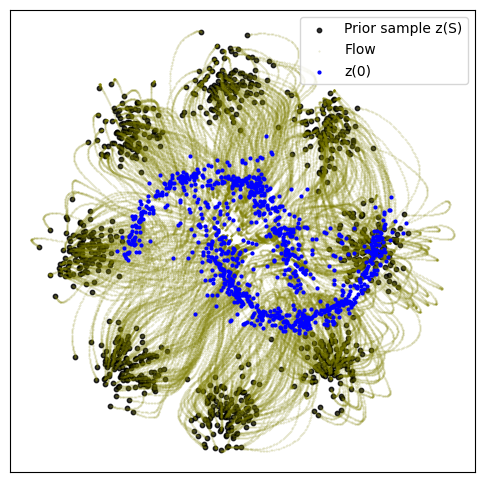

20000: loss 12.768 time 14.39


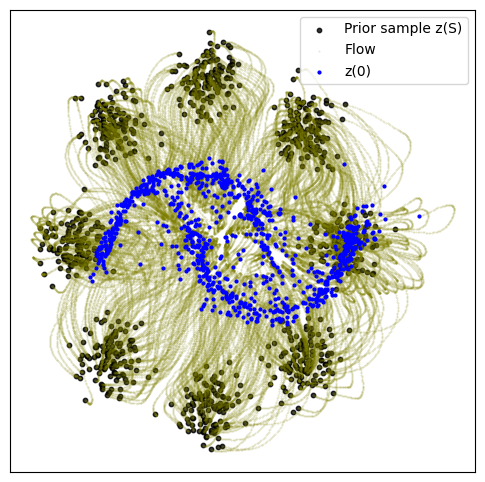

CPU times: user 57.4 s, sys: 1.33 s, total: 58.7 s
Wall time: 56.6 s


In [6]:
%%time
sigma = 0.1
dim = 2
batch_size = 256
model = MLP(dim=dim, time_varying=True)
optimizer = torch.optim.Adam(model.parameters())
pi = math.pi
FM = VariancePreservingConditionalFlowMatcher(sigma=sigma)

start = time.time()
for k in range(20000):
    optimizer.zero_grad()

    x0 = sample_8gaussians(batch_size)
    x1 = sample_moons(batch_size)

    t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)

    vt = model(torch.cat([xt, t[:, None]], dim=-1))
    loss = torch.mean((vt - ut) ** 2)

    loss.backward()
    optimizer.step()

    if (k + 1) % 5000 == 0:
        end = time.time()
        print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
        start = end
        node = NeuralODE(
            torch_wrapper(model), solver="dopri5", sensitivity="adjoint", atol=1e-4, rtol=1e-4
        )
        with torch.no_grad():
            traj = node.trajectory(
                sample_8gaussians(1024),
                t_span=torch.linspace(0, 1, 100),
            )
            plot_trajectories(traj.cpu().numpy())
torch.save(model, f"{savedir}/stochastic_interpolant_v1.pt")

### Action Matching (Neklyudov et al. 2022)

Next we try a variant called action matching. Here we parametrize the velocity field $v_\theta(t, x)$ as $\nabla s_\theta(t, x)$ where $s_\theta(t, x): \mathbb{R} \times \mathbb{R}^d \to \mathbb{R}$ is interpreted as the **action**. This is an interesting parameterization because of its link with optimal transport. Namely this velocity performs instantaneous optimal transport flow over $p_t(x)$. This is slightly different than optimal transport between marginals, but is also quite interesting. Action matching can be summarized in the following way:
$$
\begin{align}
z &= (x_0, x_1) \\
q(z) &= q(x_0)q(x_1) \\
p_t(x | z) &= \mathcal{N}(x | (1-t) x_0 + t x_1, \sigma^2)\\
L_{AM}(\theta) &= s_\theta(0, x_0) - s_\theta(1, x_1) + \frac{1}{2} \| \nabla_x s_\theta(t, x_t)\|^2 + \frac{\partial}{\partial t} s_\theta(t, x_t)
\end{align}
$$
Note that the authors again consider $\sigma = 0$ (i.e. a Dirac around $\mu_t$) but we keep the general form for consistency assuming that $\mathcal{N}(x | \mu_t, 0)$ is a degenerate Dirac centered at $\mu_t$. Our standard parameterization seems to be more difficult to fit with this loss (3-layer MLP with width 64 and SELU activations). It's unclear to me why this is the case, but as suggested in their repo using ReLU, Swish, Swish activations works much better.

In [2]:
from torchcfm.models.models import GradModel

# %%time
dim = 2
batch_size = 256
action = MLP(dim=dim, out_dim=1, time_varying=True, w=64)
model = GradModel(action)
optimizer = torch.optim.Adam(action.parameters())

start = time.time()
for k in range(20000):
    optimizer.zero_grad()
    t = torch.rand(batch_size, 1).requires_grad_(True)
    x0 = sample_8gaussians(batch_size)
    x1 = sample_moons(batch_size)
    xt = (t * x1 + (1 - t) * x0).detach().requires_grad_(True)
    st = torch.sum(action(torch.cat([xt, t], dim=-1)))
    dsdx, dsdt = torch.autograd.grad(st, (xt, t), create_graph=True, retain_graph=True)
    xt.requires_grad, t.requires_grad = False, False
    a0 = action(torch.cat([x0, torch.zeros(batch_size, 1)], dim=-1))
    a1 = action(torch.cat([x1, torch.ones(batch_size, 1)], dim=-1))
    loss = a0 - a1 + 0.5 * (dsdx**2).sum(1, keepdims=True) + dsdt
    loss = loss.mean()
    loss.backward()
    optimizer.step()

    if (k + 1) % 5000 == 0:
        end = time.time()
        print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
        start = end
        node = NeuralODE(
            torch_wrapper(model), solver="euler", sensitivity="adjoint", atol=1e-4, rtol=1e-4
        )
        # with torch.no_grad():
        traj = node.trajectory(sample_8gaussians(1024), t_span=torch.linspace(0, 1, 100)).detach()
        plot_trajectories(traj.cpu().numpy())

torch.save(model, f"{savedir}/action_matching_v1.pt")

NameError: name 'MLP' is not defined

5000: loss -10.486 time 30.21


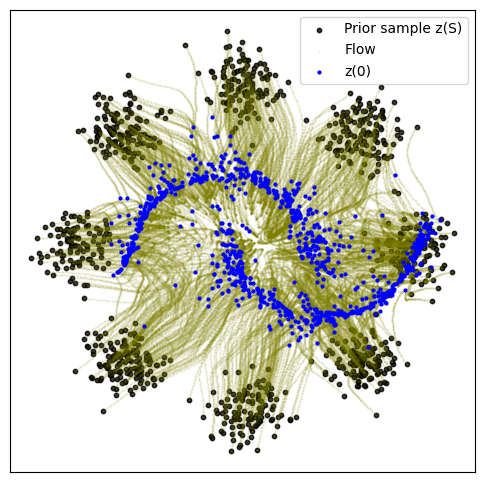

10000: loss -6.505 time 30.96


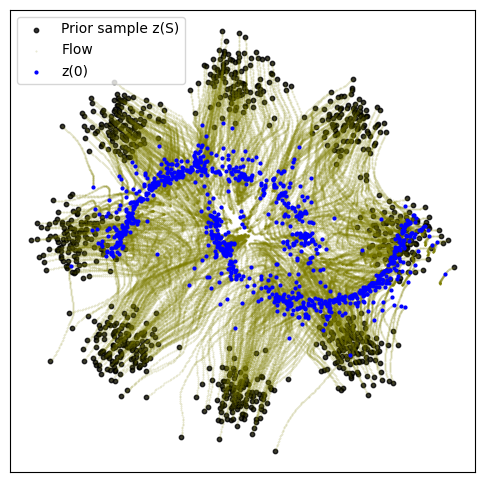

15000: loss -8.307 time 32.21


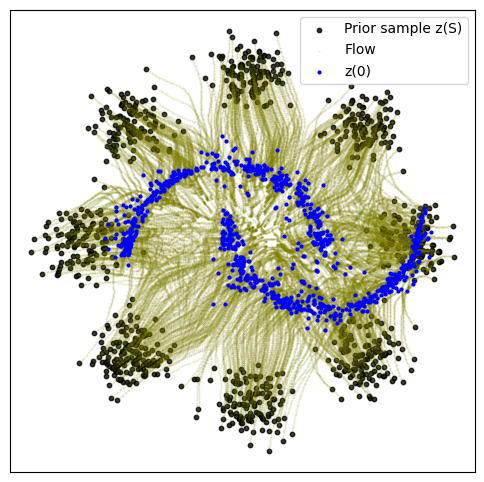

20000: loss -9.079 time 30.71


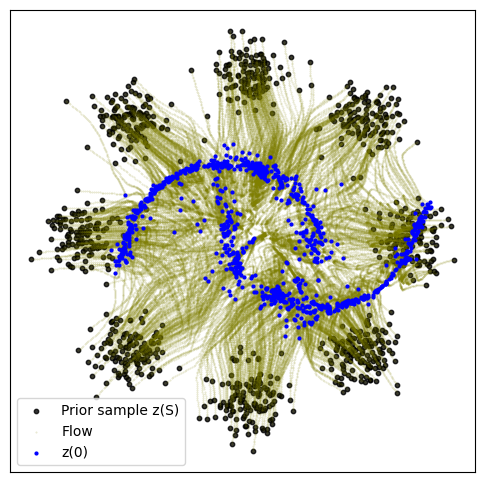

In [8]:
# %%time


class MLP2(torch.nn.Module):
    def __init__(self, dim, out_dim=None, w=64, time_varying=False):
        super().__init__()
        self.time_varying = time_varying
        if out_dim is None:
            out_dim = dim
        self.net = torch.nn.Sequential(
            torch.nn.Linear(dim + (1 if time_varying else 0), w),
            torch.nn.ReLU(),
            torch.nn.Linear(w, w),
            torch.nn.SiLU(),
            torch.nn.Linear(w, w),
            torch.nn.SiLU(),
            torch.nn.Linear(w, out_dim),
        )

    def forward(self, x):
        return self.net(x)


dim = 2
batch_size = 256
action = MLP2(dim=dim, out_dim=1, time_varying=True, w=64)
model = GradModel(action)
optimizer = torch.optim.Adam(action.parameters())

start = time.time()
for k in range(20000):
    optimizer.zero_grad()
    t = torch.rand(batch_size, 1).requires_grad_(True)
    x0 = sample_8gaussians(batch_size)
    x1 = sample_moons(batch_size)
    xt = (t * x1 + (1 - t) * x0).detach().requires_grad_(True)
    st = torch.sum(action(torch.cat([xt, t], dim=-1)))
    dsdx, dsdt = torch.autograd.grad(st, (xt, t), create_graph=True, retain_graph=True)
    xt.requires_grad, t.requires_grad = False, False
    a0 = action(torch.cat([x0, torch.zeros(batch_size, 1)], dim=-1))
    a1 = action(torch.cat([x1, torch.ones(batch_size, 1)], dim=-1))
    loss = a0 - a1 + 0.5 * (dsdx**2).sum(1, keepdims=True) + dsdt
    loss = loss.mean()
    loss.backward()
    optimizer.step()

    if (k + 1) % 5000 == 0:
        end = time.time()
        print(f"{k+1}: loss {loss.item():0.3f} time {(end - start):0.2f}")
        start = end
        node = NeuralODE(
            torch_wrapper(model), solver="euler", sensitivity="adjoint", atol=1e-4, rtol=1e-4
        )
        # with torch.no_grad():
        traj = node.trajectory(
            sample_8gaussians(1024),
            t_span=torch.linspace(0, 1, 100),
        ).detach()
        plot_trajectories(traj.cpu().numpy())
torch.save(model, f"{savedir}/action_matching_swish_v1.pt")